In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from torch.utils.tensorboard import SummaryWriter

# Sinusoidal Positional Encoding
def get_sinusoidal_encoding(seq_len, embed_dim):
    pe = torch.zeros(seq_len, embed_dim)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Improved Multi-task Transformer Encoder 
class MultiTaskNumericEncoder(nn.Module):
    def __init__(self, seq_len, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len

        self.value_embedding = nn.Linear(1, embed_dim)

        pos_enc = get_sinusoidal_encoding(seq_len, embed_dim)
        self.register_buffer("pos_enc", pos_enc.unsqueeze(0))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classification_head = nn.Linear(embed_dim, 1)
        self.regression_head = nn.Linear(embed_dim, 1)

    def forward(self, x_hidden):
        x_embed = self.value_embedding(x_hidden.unsqueeze(-1)) + self.pos_enc

        encoder_output = self.transformer_encoder(x_embed)

        class_logits = self.classification_head(encoder_output).squeeze(-1)
        classification_output = torch.sigmoid(class_logits)
        regression_output = self.regression_head(encoder_output).squeeze(-1)

        return classification_output, regression_output


In [ ]:
# Training function with metrics logging and checkpointing
def train_model(model, train_loader, val_loader, epochs, lr=1e-4, alpha=0.5, device='cuda'):
    criterion_class = nn.BCELoss()
    criterion_reg = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    model.to(device)

    writer = SummaryWriter()

    best_metrics = {}
    steps_per_epoch = len(train_loader)
    eval_interval = max(1, steps_per_epoch // 10)
    i=0

    for epoch in range(epochs):
        model.train()
        for step, batch in enumerate(train_loader):
            x_filled = batch['x_hidden'].to(device)
            nan_mask = batch['nan_mask'].to(device)
            training_mask = batch['training_mask'].to(device)
            x_original = batch['x_original'].to(device)
            classification_output, regression_output = model(x_filled)

            class_loss = criterion_class(classification_output, nan_mask)
            reg_loss = criterion_reg(regression_output*training_mask, x_original*training_mask)

            total_loss = alpha * class_loss + (1 - alpha) * reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if step % eval_interval == 0 or step == steps_per_epoch - 1:
                print(f"Eval Number: {i}")
                i+=1
                model.eval()
                for phase, loader in [('Train', train_loader), ('Validation', val_loader)]:
                    all_nan_masks, all_train_masks = [], []
                    all_targets, all_preds_class, all_preds_reg = [], [], []

                    with torch.no_grad():
                        for batch in loader:
                            x_filled = batch['x_hidden'].to(device)
                            nan_mask = batch['nan_mask'].to(device)
                            training_mask = batch['training_mask'].to(device)
                            x_original = batch['x_original'].to(device)
                            val_class_out, val_reg_out = model(x_filled)

                            all_nan_masks.extend(nan_mask.cpu().numpy().flatten())
                            all_train_masks.extend(training_mask.cpu().numpy().flatten())
                            all_targets.extend(x_original.cpu().numpy().flatten())
                            all_preds_class.extend(val_class_out.cpu().numpy().flatten())
                            all_preds_reg.extend(val_reg_out.cpu().numpy().flatten())

                    # Classification metrics: Evaluate original missingness prediction (nan_mask)
                    class_mask_indices = np.array(all_nan_masks) >= 0  # Evaluate classification everywhere
                    bin_preds = (np.array(all_preds_class)[class_mask_indices] > 0.5).astype(int)
                    bin_targets = np.array(all_nan_masks)[class_mask_indices]

                    # Regression metrics: Evaluate only on hidden-for-training positions (training_mask)
                    reg_mask_indices = np.array(all_train_masks) == 1
                    reg_preds = np.array(all_preds_reg)[reg_mask_indices]
                    reg_targets = np.array(all_targets)[reg_mask_indices]

                    metrics = {}

                    # Classification metrics (Sometimes no missing classes)
                    if len(np.unique(bin_targets)) > 1:
                        metrics.update({
                            'F1': f1_score(bin_targets, bin_preds),
                            'Precision': precision_score(bin_targets, bin_preds),
                            'Recall': recall_score(bin_targets, bin_preds),
                            'ROC-AUC': roc_auc_score(bin_targets, np.array(all_preds_class)[class_mask_indices])
                        })

                    # Regression metrics (veryy slim possibiliy empty)
                    if reg_targets.size > 0:
                        metrics.update({
                            'MSE': mean_squared_error(reg_targets, reg_preds),
                            'MAE': mean_absolute_error(reg_targets, reg_preds),
                            'R2': r2_score(reg_targets, reg_preds)
                        })

                    # Log metrics safely
                    for metric_name, metric_value in metrics.items():
                        writer.add_scalar(f'{phase}/{metric_name}', metric_value, epoch * steps_per_epoch + step)
                        if phase == 'Validation':
                            if metric_name not in best_metrics or \
                                (metric_name in ['MSE', 'MAE'] and metric_value < best_metrics[metric_name]) or \
                                (metric_name not in ['MSE', 'MAE'] and metric_value > best_metrics[metric_name]):
                                best_metrics[metric_name] = metric_value
                                checkpoint = {
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                }
                                torch.save(checkpoint, f'D:\\Mouse\\Notebooks\\Models\\checkpoint_best_{metric_name}_{metric_value}.pt')
                    
                model.train()

        scheduler.step()

    writer.close()

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

samples = np.load('samples43Regions.npy')

class MaskedNumericDataset(Dataset):
    def __init__(self, data_original, data_hidden, nan_mask_tensor, training_mask_tensor):
        self.data_original = data_original
        self.data_hidden = data_hidden
        self.nan_mask = nan_mask_tensor
        self.training_mask = training_mask_tensor

    def __len__(self):
        return self.data_original.shape[0]

    def __getitem__(self, idx):
        return {
            'x_original': self.data_original[idx],
            'x_hidden': self.data_hidden[idx],
            'nan_mask': self.nan_mask[idx],
            'training_mask': self.training_mask[idx]
        }


# Prepare data function ensuring at least 1 hidden position
def prepare_data(data, hidden_fraction=0.3):
    # Create a mask indicating which positions were originally NaN
    nan_mask = np.isnan(data).astype(np.float32)
    # Initialize a hidden mask (all zeros) with the same shape as the data
    hidden_mask = np.zeros_like(data, dtype=np.float32)
    
    # Determine the total number of features per sample
    num_features = data.shape[1]
    
    for i in range(len(data)):
        # Use all indices (both NaNs and values)
        all_indices = np.arange(num_features)
        # Compute the number of hidden positions
        num_hidden = int(num_features * hidden_fraction)
        
        # Randomly select indices from all available indices
        hidden_indices = np.random.choice(all_indices, size=num_hidden, replace=False)
        hidden_mask[i, hidden_indices] = 1
    
    # Replace NaN values with 0.0, then set hidden positions to 0.0 as well
    data_original = np.nan_to_num(data, nan=0.0)
    data_hidden = data_original.copy()
    data_hidden[hidden_mask == 1] = 0.0

    data_original = torch.tensor(data_original, dtype=torch.float32)
    data_hidden = torch.tensor(data_hidden, dtype=torch.float32)
    nan_mask_tensor = torch.tensor(nan_mask, dtype=torch.float32)
    training_mask_tensor = torch.tensor(hidden_mask, dtype=torch.float32)

    return data_original, data_hidden, nan_mask_tensor, training_mask_tensor


train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42)

train_dataset = MaskedNumericDataset(*prepare_data(train_data))
test_dataset = MaskedNumericDataset(*prepare_data(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

input_dim = samples.shape[1]  # which is 43
model = MultiTaskNumericEncoder(input_dim, embed_dim=256, num_heads=4, num_layers=6, dropout=0.1)

# train_model(model, train_loader, test_loader, epochs=11, lr=1e-4, alpha=0.5)


In [ ]:
# Get the first batch from the DataLoader
batch = next(iter(train_loader))
print("Original Input values:\n", batch['x_original'].detach().cpu().numpy())
print("Hidden Input values:\n", batch['x_hidden'].detach().cpu().numpy())
print("NaN Mask values:\n", batch['nan_mask'].detach().cpu().numpy())
print("Training Mask values:\n", batch['training_mask'].detach().cpu().numpy())

Original Input values:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         5.0628905  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01129913 ... 0.         0.         0.        ]]
Hidden Input values:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         5.0628905  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01129913 ... 0.         0.         0.        ]]
NaN Mask values:
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.

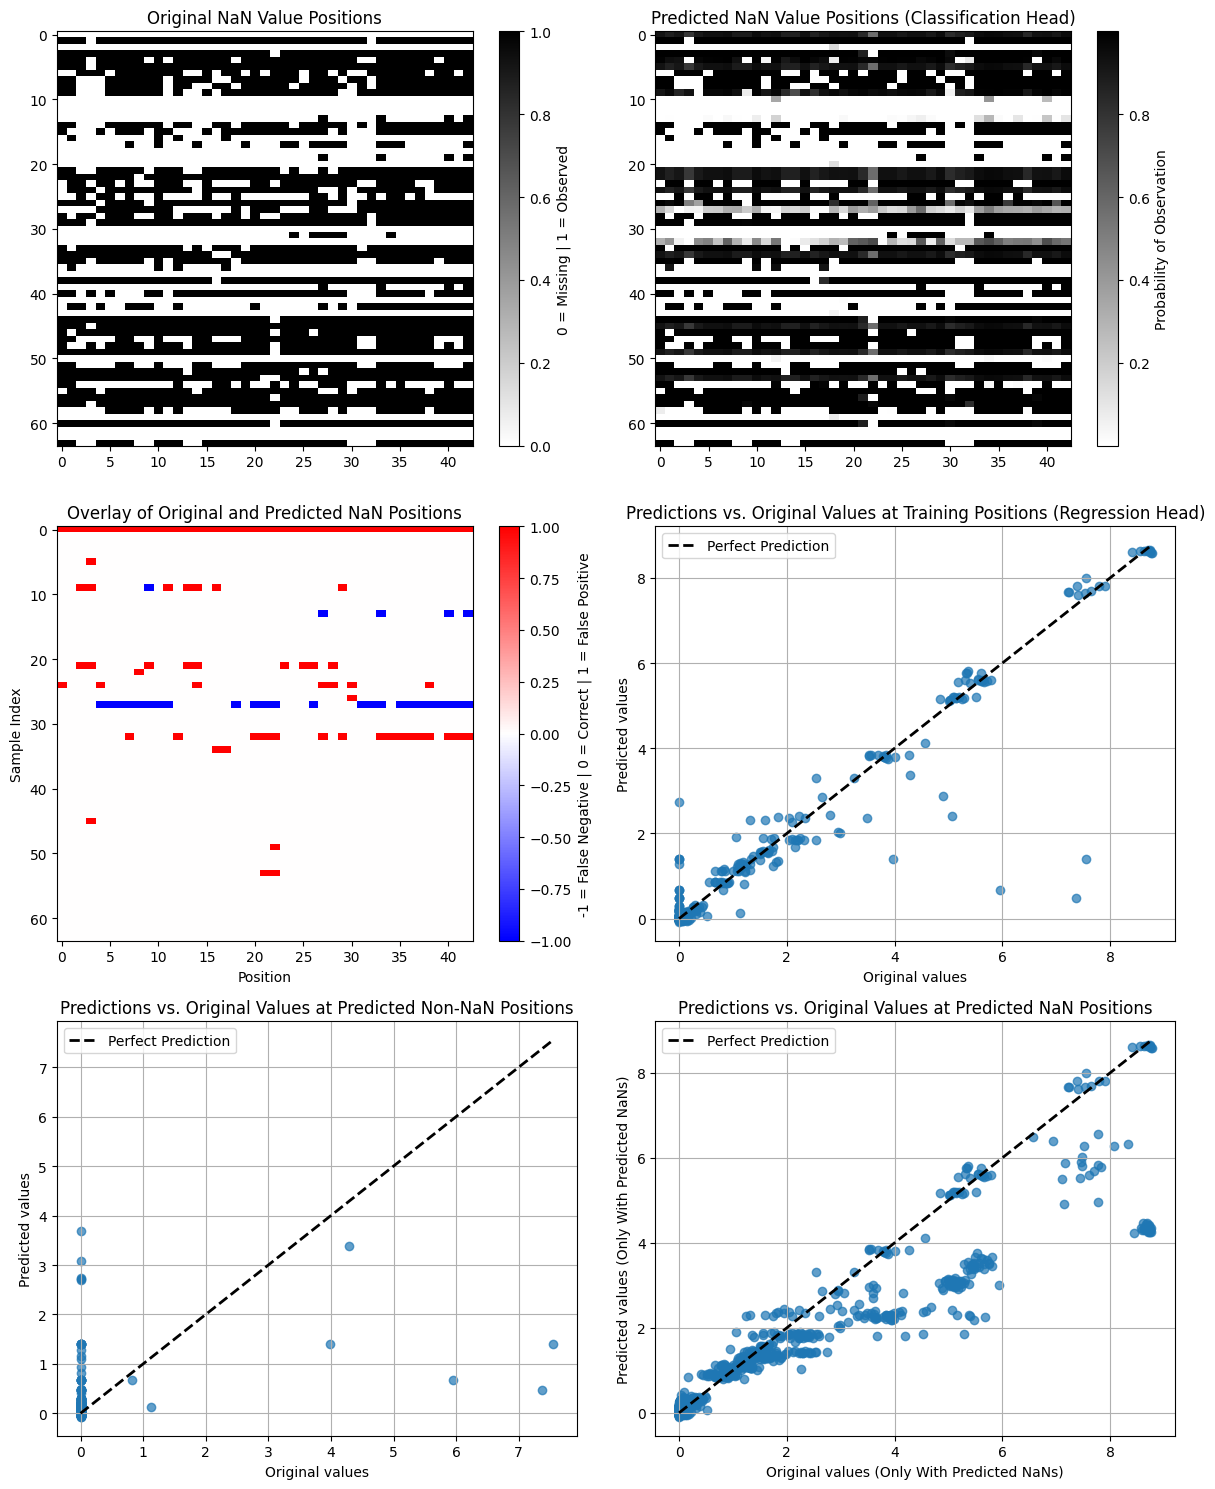

In [32]:
import torch
import matplotlib.pyplot as plt

# Load checkpoint
checkpoint_path = r"D:\Mouse\Notebooks\Models\checkpoint_best_MAE_0.10058323293924332.pt" 
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Ensure model structure is defined before loading checkpoint
model = MultiTaskNumericEncoder(input_dim, embed_dim=256, num_heads=4, num_layers=6, dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get one batch from test loader
batch = next(iter(test_loader))

with torch.no_grad():
    classification_pred, regression_pred = model(batch['x_hidden'])

# Extract positions hidden for training
training_positions = batch['training_mask'].bool().cpu().numpy()

# Classification
original_NaN_mask = batch['nan_mask'].cpu().numpy()
classification_pred = classification_pred.detach().cpu().numpy()
pred_binary = (classification_pred > 0.5).astype(int) # Threshold 0.5
difference_map = pred_binary - original_NaN_mask

# Regression
original_value = batch['x_original'].cpu().numpy()[training_positions]
regression_pred_value = regression_pred.detach().cpu().numpy()[training_positions]
# Extract positions where the model predicted "observed" (classification_pred > 0.5)
pred_observed_positions = classification_pred > 0.5
# Filter original values and regression predictions
filtered_original_value = batch['x_original'].cpu().numpy()[pred_observed_positions]
filtered_regression_pred = regression_pred.detach().cpu().numpy()[pred_observed_positions]
# For Predicted NaNs
NaN_filtered_original_value = batch['x_original'].cpu().numpy()[~pred_observed_positions]
NaN_filtered_regression_pred = regression_pred.detach().cpu().numpy()[~pred_observed_positions]


# Plot both heatmaps side by side
plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
plt.imshow(original_NaN_mask, cmap='gray_r', aspect='auto')
plt.title('Original NaN Value Positions')
plt.colorbar(label='0 = Missing | 1 = Observed')

plt.subplot(3, 2, 2)
plt.imshow(classification_pred, cmap='gray_r', aspect='auto')
plt.title('Predicted NaN Value Positions (Classification Head)')
plt.colorbar(label='Probability of Observation')

plt.subplot(3, 2, 3)
plt.imshow(difference_map, cmap='bwr', aspect='auto')  # 'bwr' = blue (FN) / red (FP)
plt.colorbar(label='-1 = False Negative | 0 = Correct | 1 = False Positive')
plt.title('Overlay of Original and Predicted NaN Positions')
plt.xlabel('Position')
plt.ylabel('Sample Index')
plt.grid(False)

plt.subplot(3, 2, 4)
plt.scatter(original_value, regression_pred_value, alpha=0.7)
plt.plot([min(original_value), max(original_value)], [min(original_value), max(original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Training Positions (Regression Head)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.scatter(filtered_original_value, filtered_regression_pred, alpha=0.7)
plt.plot([min(filtered_original_value), max(filtered_original_value)], [min(filtered_original_value), max(filtered_original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs. Original Values at Predicted Non-NaN Positions')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.scatter(NaN_filtered_original_value, NaN_filtered_regression_pred, alpha=0.7)
plt.plot([min(NaN_filtered_original_value), max(NaN_filtered_original_value)], [min(NaN_filtered_original_value), max(NaN_filtered_original_value)], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Original values (Only With Predicted NaNs)')
plt.ylabel('Predicted values (Only With Predicted NaNs)')
plt.title('Predictions vs. Original Values at Predicted NaN Positions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
